In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import string
from unidecode import unidecode
from tqdm import tqdm

# 1. EDA

Explorative analysis to understand the dataset.


First 5 rows of the dataset:


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0



Dataset information:
Number of rows: 159571
Number of columns: 8

Columns in the dataset:
['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']

Data types:


comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
sum_injurious     int64
dtype: object


Missing values per column:


comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


Distribution of toxicity categories:
toxic: 15294 comments (9.58%)
severe_toxic: 1595 comments (1.00%)
obscene: 8449 comments (5.29%)
threat: 478 comments (0.30%)
insult: 7877 comments (4.94%)
identity_hate: 1405 comments (0.88%)

Distribution of number of labels per comment:


num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

Percentage of non-toxic comments: 89.83%

Statistics on comment length:


count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

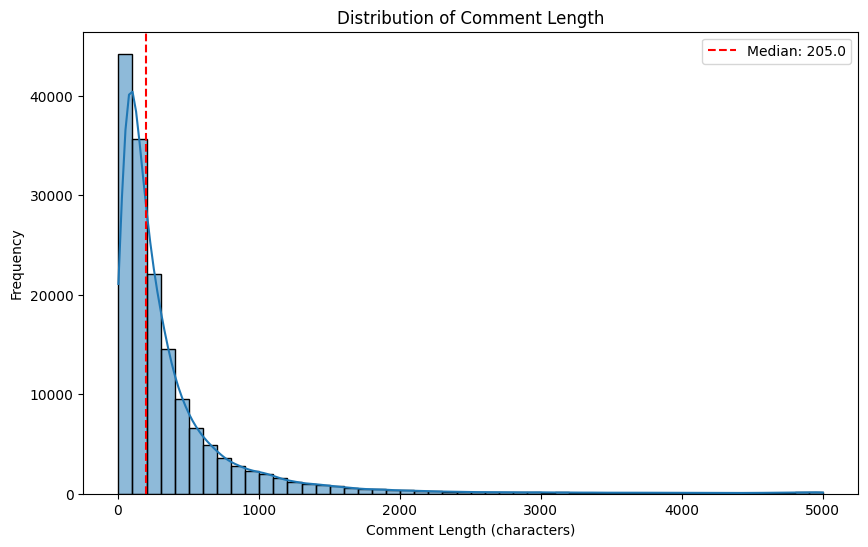


Examples of comments for each category:

--- Example of 'toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'severe_toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'obscene' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'threat' comment ---
Hi! I am back again!
Last warning!
Stop undoing my edits or die!

--- Example of 'insult' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'identity_hate' comment ---
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gyp...


In [2]:
df = pd.read_csv('Filter_Toxic_Comments_dataset.csv')

print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\nData types:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isnull().sum())

toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Class distribution (how many comments per category)
print("\nDistribution of toxicity categories:")
for label in toxic_labels:
    count = df[label].sum()
    percentage = (count / len(df)) * 100
    print(f"{label}: {count} comments ({percentage:.2f}%)")

# Count of comments with multiple labels
df['num_labels'] = df[toxic_labels].sum(axis=1)
print("\nDistribution of number of labels per comment:")
display(df['num_labels'].value_counts().sort_index())
print(f"Percentage of non-toxic comments: {(df['num_labels'] == 0).mean() * 100:.2f}%")

# Comment length
df['comment_length'] = df['comment_text'].apply(len)
print("\nStatistics on comment length:")
display(df['comment_length'].describe())

# Visualization of comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['comment_length'].median(), color='r', linestyle='--', label=f'Median: {df["comment_length"].median()}')
plt.legend()
plt.show()

# Examples of comments for each category
print("\nExamples of comments for each category:")
for label in toxic_labels:
    print(f"\n--- Example of '{label}' comment ---")
    example = df[df[label] == 1]['comment_text'].iloc[0]
    print(example[:200] + "..." if len(example) > 200 else example)


Analyzing comments with multiple toxicity labels:

Most common label combinations:


/tmp/ipykernel_20642/3695296090.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)


toxic                                              5666
toxic-obscene-insult                               3800
toxic-obscene                                      1758
toxic-insult                                       1215
toxic-severe_toxic-obscene-insult                   989
toxic-obscene-insult-identity_hate                  618
obscene                                             317
insult                                              301
toxic-severe_toxic-obscene-insult-identity_hate     265
obscene-insult                                      181
Name: count, dtype: int64

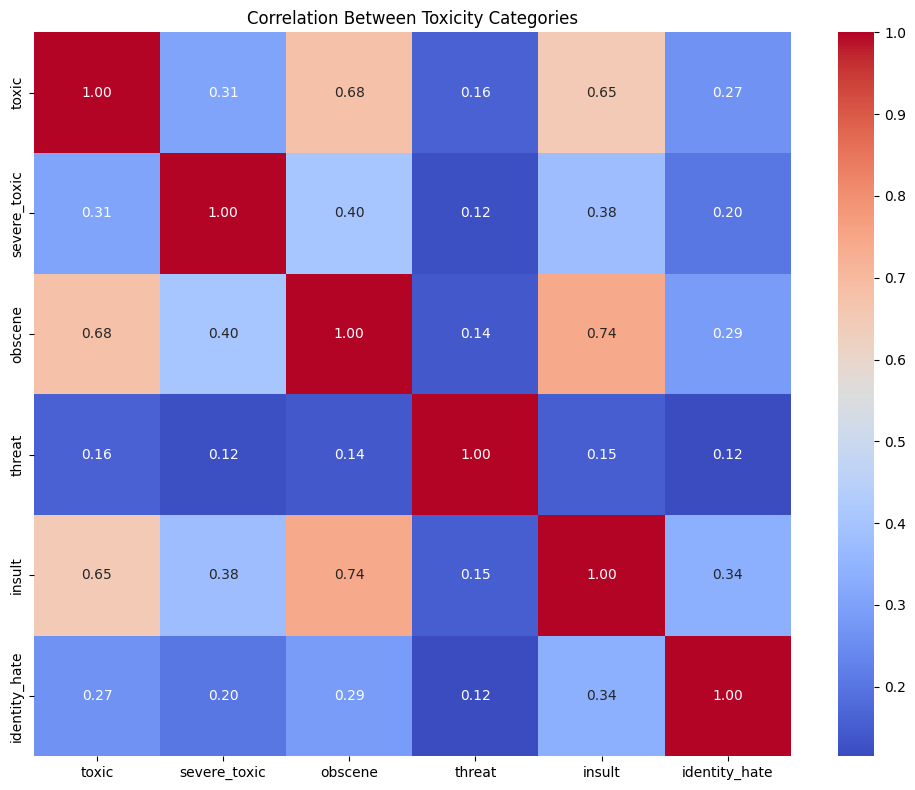

In [3]:
# Analyze comments with multiple labels
print("\nAnalyzing comments with multiple toxicity labels:")

# Count occurrences of label combinations
print("\nMost common label combinations:")
label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)
top_combos = label_combos[label_combos != ''].value_counts().head(10)
display(top_combos)

plt.figure(figsize=(10, 8))
corr_matrix = df[toxic_labels].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Toxicity Categories")
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

In [ ]:
def normalize_text(text):
    """
    Normalize text with various techniques:
    - Convert to lowercase
    - Replace URLs with <URL> placeholder
    - Replace user mentions with <USER> placeholder
    - Handle emojis (convert to text)
    - Fix character repetitions ("sccccemo" → "scemo")
    - Convert leet speak ("1d10t" → "idiot")
    - Normalize unicode characters to ASCII
    - Standardize spacing
    """
    # Check if text is a string (some entries might be NaN)
    if not isinstance(text, str):
        return ""
    
    
    text = text.lower()

    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '<URL>', text)
    
    mention_pattern = r'@\w+'
    text = re.sub(mention_pattern, '<USER>', text)
    
    text = emoji.demojize(text)
    
    # Fix character repetitions (more than 2 of the same character)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
	# Identify and preserve dates and times before leet speak conversion
    # First, temporarily mark date/time patterns
    date_patterns = [
        # Time patterns (HH:MM)
        r'\b\d{1,2}:\d{2}\b',
        # Date patterns (MM/DD/YYYY, DD/MM/YYYY, YYYY/MM/DD)
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b',
        r'\b\d{2,4}-\d{1,2}-\d{1,2}\b',
        # Month name patterns
        r'\b\d{1,2}\s+(?:january|february|march|april|may|june|july|august|september|october|november|december)\b',
        r'\b(?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2}\b',
    ]
    
    # Temporary placeholders for dates/times
    date_replacements = {}
    for i, pattern in enumerate(date_patterns):
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for j, match in enumerate(matches):
            placeholder = f"<DATE_TIME_{i}_{j}>"
            date_replacements[placeholder] = match.group()
            text = text.replace(match.group(), placeholder)
            
    # Convert common leet speak patterns
    leet_patterns = {
        '0': 'o', '1': 'i', '3': 'e', '4': 'a', '5': 's', 
        '6': 'g', '7': 't', '8': 'b', '@': 'a', '$': 's'
    }
    for digit, letter in leet_patterns.items():
        text = text.replace(digit, letter)
    
    # Normalize unicode characters (optional - can be commented out if needed)
    text = unidecode(text)
    
    # Replace numbers with <NUM> placeholder
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    
    # Standardize spacing (remove extra spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Normalizing text data...


100%|██████████| 159571/159571 [01:02<00:00, 2554.53it/s]



Examples of original vs. normalized text:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
Normalized: explanation why the edits made under my username hardcore metallica fan were reverted? they weren't ...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11...
Normalized: d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) 2i:si, january ii,...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant ...
Normalized: hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant ...

Original: "
More
I can't make any real suggestions on improvement - I wondered if the section statistics shoul...
Normalized: " more i can't make any real suggestions on improvement - i wondered if the section statistics shoul...

Original: You, sir, are my hero.

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


Statistics on text length after normalization:


count    159571.000000
mean        387.455158
std         581.050164
min           5.000000
25%          93.000000
50%         201.000000
75%         429.000000
max        5165.000000
Name: normalized_length, dtype: float64

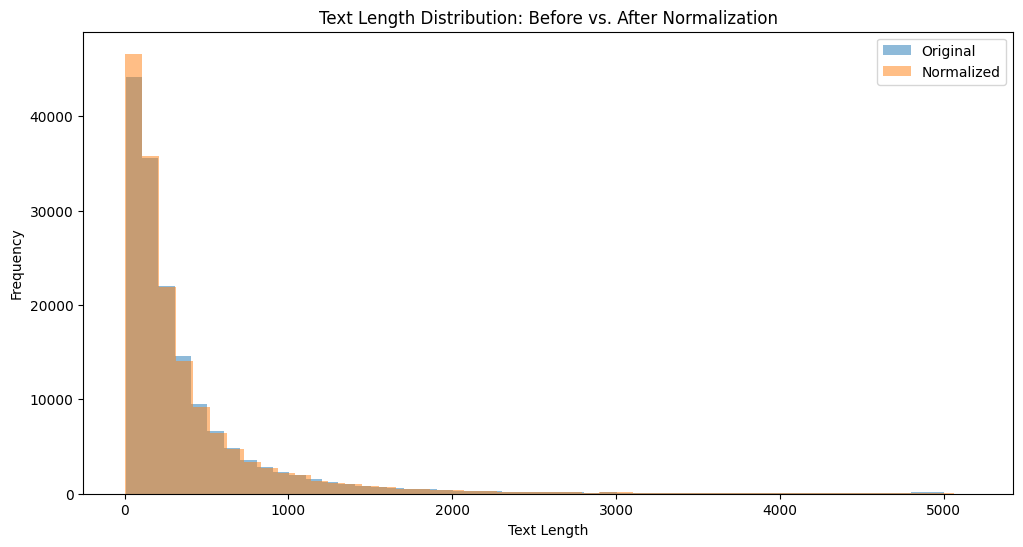

In [5]:
# Apply normalization to the dataset with progress bar
print("Normalizing text data...")
df['normalized_text'] = [normalize_text(text) for text in tqdm(df['comment_text'])]

# Display examples of original vs. normalized text
print("\nExamples of original vs. normalized text:")
for i in range(5):
    print(f"\nOriginal: {df['comment_text'].iloc[i][:100]}...")
    print(f"Normalized: {df['normalized_text'].iloc[i][:100]}...")

# Check if there are any remaining empty texts after normalization
empty_texts = df['normalized_text'].apply(lambda x: len(x) == 0).sum()
print(f"\nNumber of empty texts after normalization: {empty_texts}")

# Show statistics on text length before and after normalization
df['normalized_length'] = df['normalized_text'].apply(len)
print("\nStatistics on text length before normalization:")
display(df['comment_length'].describe())
print("\nStatistics on text length after normalization:")
display(df['normalized_length'].describe())

# Visualize the difference in text length
plt.figure(figsize=(12, 6))
plt.hist(df['comment_length'], bins=50, alpha=0.5, label='Original')
plt.hist(df['normalized_length'], bins=50, alpha=0.5, label='Normalized')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution: Before vs. After Normalization')
plt.legend()
plt.show()